# Fine-tuning YOLOv8 en DocBank Dataset

Este notebook guiará el proceso de fine-tuning de YOLOv8 en el dataset DocBank. El proceso se divide en los siguientes pasos:

1. Configuración del entorno
2. Descarga y preparación del dataset DocBank
3. Entrenamiento del modelo YOLOv8
4. Evaluación y exportación del modelo

## 1. Configuración del entorno

Primero, instalemos las dependencias necesarias y configuremos el entorno.

In [ ]:
!pip install ultralytics opencv-python tqdm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

### Imports y requisitos del código

In [ ]:
import os
import json
import shutil
from pathlib import Path
import requests
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from google.colab import drive
import zipfile
import subprocess
import time
import yaml
from collections import defaultdict
from ultralytics import YOLO
from PIL import Image, ImageDraw
import random
import torch
import matplotlib.pyplot as plt

print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPU disponible: True
GPU: NVIDIA A100-SXM4-40GB


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. Descarga y preparación del dataset DocBank

Ahora, vamos a crear las funciones necesarias para descargar y preparar el dataset DocBank.

In [ ]:
def extract_zip(zip_file, extract_dir, images_source_dir):
    """Extrae archivos del zip que contengan en su nombre el nombre base de un
    .jpg en images_source_dir, ignorando el sufijo '_ori'

      Se almacenan las anotaciones extraidas del zip en 'extract_dir'
    """

    print(f"Extrayendo {zip_file}...")
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            files = zip_ref.namelist()

            # Obtener los nombres base de los .jpg, eliminando el sufijo '_ori' si está presente
            jpg_basenames = set([
                img_path.stem.replace('_ori', '')
                for img_path in Path(images_source_dir).glob('*.jpg')
            ])
            print(f"JPG BASENAMES (sin '_ori'): {jpg_basenames}")

            for file in files:
                file_stem = Path(file).stem
                for jpg_name in jpg_basenames:
                    if jpg_name in file_stem:
                        print(f"Copiando {file} a {extract_dir} porque contiene '{jpg_name}'")
                        zip_ref.extract(file, extract_dir)
                        break  # Ya se encontró una coincidencia
    except zipfile.BadZipFile:
        print(f"Error: {zip_file} no es un archivo zip válido")
        raise



In [ ]:
# Extract annotations zip
drive.mount('/content/drive', force_remount=True)
dataset_dir = Path('/content/drive/MyDrive/yoloDocBankPoc/Annotations')
annotations_zip = Path('/content/drive/MyDrive/DocBank_500K_txt.zip')
images_source_dir = Path('/content/drive/MyDrive/SmallSmallBatch')

dataset_dir.mkdir(parents=True, exist_ok=True)

extract_zip(annotations_zip, dataset_dir, images_source_dir)

Mounted at /content/drive


In [ ]:
def prepare_docbank():
    """Prepara el dataset DocBank para YOLOv8 copiando imágenes y anotaciones a subcarpetas nuevas."""

    # Directorios base
    dataset_dir = Path('/content/drive/MyDrive/yoloDocBankPoc')
    images_source_dir = Path('/content/drive/MyDrive/SmallSmallBatch')
    annotations_dir = dataset_dir / 'Annotations/DocBank_500K_txt'

    images_dir = dataset_dir / 'images'
    labels_dir = dataset_dir / 'transformed_labels'

    # Crear estructura de directorios sin modificar archivos originales
    for split in ['train', 'val', 'test']:
        (images_dir / split).mkdir(parents=True, exist_ok=True)
        (labels_dir / split).mkdir(parents=True, exist_ok=True)

    # Obtener imágenes .jpg
    all_image_files = list(images_source_dir.glob('*.jpg'))
    np.random.shuffle(all_image_files)

    # Crear splits
    train_size = int(0.8 * len(all_image_files))
    val_size = int(0.1 * len(all_image_files))

    train_files = all_image_files[:train_size]
    val_files = all_image_files[train_size:train_size + val_size]
    test_files = all_image_files[train_size + val_size:]

    splits = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }

    # Procesar cada split
    for split_name, image_files in splits.items():
        print(f"📁 Procesando split: {split_name}")
        for img_file in tqdm(image_files):
            raw_stem = img_file.stem
            base_name = raw_stem.replace('_ori', '')

            # Copiar imagen con su nombre original
            dest_img_path = images_dir / split_name / img_file.name
            shutil.copy(img_file, dest_img_path)

            # Buscar anotación correspondiente
            txt_file = annotations_dir / f"{base_name}.txt"
            if not txt_file.exists():
                print(f"⚠️ No hay anotación para: {base_name}")
                continue

            # Copiar anotación directamente ya que está en formato YOLO
            dest_label_path = labels_dir / split_name / f"{raw_stem}.txt" #raw_stem o base_name.... ? testear.
            shutil.copy(txt_file, dest_label_path)

    print("✅ ¡Dataset preparado con copias seguras!")


In [ ]:
# Paso 1: Preparar el dataset
prepare_docbank()

In [ ]:
def read_annotations(file_path):
    """Read the text annotations file and return a list of annotations."""
    annotations = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 5:  # Ensure we have at least the basic required fields
                word = parts[0]
                x1, y1, x2, y2 = map(int, parts[1:5])
                annotations.append({
                    'word': word,
                    'x1': x1,
                    'y1': y1,
                    'x2': x2,
                    'y2': y2
                })
    return annotations

def group_by_lines(annotations, y_threshold=5):
    """Group annotations into lines based on y-coordinates."""
    # Sort annotations by y-coordinate
    sorted_anns = sorted(annotations, key=lambda x: x['y1'])

    lines = []
    current_line = []
    current_y = None

    for ann in sorted_anns:
        if current_y is None:
            current_y = ann['y1']
            current_line.append(ann)
        elif abs(ann['y1'] - current_y) <= y_threshold:
            current_line.append(ann)
        else:
            # Sort words in line by x-coordinate
            current_line.sort(key=lambda x: x['x1'])
            lines.append(current_line)
            current_line = [ann]
            current_y = ann['y1']

    if current_line:
        current_line.sort(key=lambda x: x['x1'])
        lines.append(current_line)

    return lines

def convert_to_yolo_format(lines, img_width, img_height):
    """Convert grouped lines to YOLO format."""
    yolo_annotations = []

    for line in lines:
        # Get the bounding box for the entire line
        x1 = min(word['x1'] for word in line)
        y1 = min(word['y1'] for word in line)
        x2 = max(word['x2'] for word in line)
        y2 = max(word['y2'] for word in line)

        # Convert to YOLO format (normalized)
        x_center = ((x1 + x2) / 2) / img_width
        y_center = ((y1 + y2) / 2) / img_height
        width = (x2 - x1) / img_width
        height = (y2 - y1) / img_height

        # Class 0 for text (you can modify this based on your needs)
        yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_annotations

def process_file(input_file, output_file, img_width, img_height):
    """Process a single file from text format to YOLO format."""
    # Read annotations
    annotations = read_annotations(input_file)

    # Group into lines
    lines = group_by_lines(annotations)

    # Convert to YOLO format
    yolo_annotations = convert_to_yolo_format(lines, img_width, img_height)

    # Create output directory if it doesn't exist
    output_file.parent.mkdir(parents=True, exist_ok=True)

    # Write to output file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(yolo_annotations))

def process_directory(input_dir, output_dir, img_width, img_height):
    """Process all .txt files in the input directory and save to output directory."""
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    # Create output directory if it doesn't exist
    output_path.mkdir(parents=True, exist_ok=True)

    # Process each .txt file
    for txt_file in input_path.glob('*.txt'):
        # Create corresponding output file path
        output_file = output_path / txt_file.name

        print(f"Processing {txt_file.name}...")
        process_file(txt_file, output_file, img_width, img_height)
        print(f"Saved to {output_file}")

def transform_to_yolo():
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Define paths
    input_dir = "/content/drive/MyDrive/yoloDocBankPoc/transformed_labels/val"  # Your input directory
    output_dir = "/content/drive/MyDrive/yoloDocBankPoc/labels/val"  # Your output directory

    # Image dimensions (adjust these based on your actual image sizes)
    img_width = 1000
    img_height = 1000

    # Process all files
    process_directory(input_dir, output_dir, img_width, img_height)

    input_dir = "/content/drive/MyDrive/yoloDocBankPoc/transformed_labels/train"  # Your input directory
    output_dir = "/content/drive/MyDrive/yoloDocBankPoc/labels/train"  # Your output directory

    # Image dimensions (adjust these based on your actual image sizes)
    img_width = 1000
    img_height = 1000

    # Process all files
    process_directory(input_dir, output_dir, img_width, img_height)

    input_dir = "/content/drive/MyDrive/yoloDocBankPoc/transformed_labels/test"  # Your input directory
    output_dir = "/content/drive/MyDrive/yoloDocBankPoc/labels/test"  # Your output directory

    # Image dimensions (adjust these based on your actual image sizes)
    img_width = 1000
    img_height = 1000

    # Process all files
    process_directory(input_dir, output_dir, img_width, img_height)


In [ ]:
transform_to_yolo()

## 3. Carga del modelo y evaluación de los datos

Ahora realizaremos una evaluación previa al entrenamiento del modelo.

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign
import torch.nn as nn

class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn_pre_nms_top_n_train=1000, rpn_pre_nms_top_n_test=2000, #Updated to 3000 taking into consideration the max amount of words per page
                 rpn_post_nms_top_n_train=1000, rpn_post_nms_top_n_test=2000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=256, box_positive_fraction=0.25,
                 bbox_reg_weights=None, num_classes=91):
        super().__init__()
        # First, set the backbone that we will use to extract the feature maps
        self.backbone = backbone

        out_channels = backbone.out_channels
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

        # Declare the anchor generator of the Region Proposal Network (RPN)
        rpn_anchor_generator = AnchorGenerator(
            anchor_sizes, aspect_ratios
        )

        # Declare the Head of the RPN that will classify the proposals
        rpn_head = RPNHead(
            out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
        )
        rpn_pre_nms_top_n = {"training": rpn_pre_nms_top_n_train, "testing": rpn_pre_nms_top_n_test}
        rpn_post_nms_top_n = {"training": rpn_post_nms_top_n_train, "testing": rpn_post_nms_top_n_test}

        # Create the RPN combining the anchor generator and the head
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        # ROI Align
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)

        resolution = box_roi_pool.output_size[0]
        representation_size = 1024

        # Simple Head made of 2 Fully Connected layers
        box_head = None #we will set them in the exercises

        representation_size = 1024

        # Predictor with 2 outputs (scores and Bounding Boxes deltas)
        box_predictor = None #we will set them in the exercises

        # Module that combines the last modules to compute the prediction of every box and match
        # targets and proposalt in training
        self.roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)
        min_size=512
        max_size=960
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]

        # Module that does the correct data augmentation
        self.transform = GeneralizedRCNNTransform(min_size, max_size, self.image_mean, self.image_std)

    def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]])
        """
        Arguments:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).

        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        original_image_sizes = []
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)
        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([('0', features)])
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        return detections, losses

In [ ]:
class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Arguments:
        in_size (int): number of inputs
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_size, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_size, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        # Flatten the input tensor: [batch, 256, 7, 7] -> [batch, 256*7*7]
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

In [ ]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Arguments:
        in_size (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_size, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_size, num_classes)
        self.bbox_pred = nn.Linear(in_size, 4 * num_classes)

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import TwoMLPHead
from torchvision.models import resnet50
from torchvision.models.detection.backbone_utils import BackboneWithFPN

# 1. Create model with backbone
backbone = resnet50(pretrained=True, norm_layer=nn.BatchNorm2d)
backbone = BackboneWithFPN(
    backbone,
    return_layers={"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"},
    in_channels_list=[256, 512, 1024, 2048],
    out_channels=256
)
model = FasterRCNN(backbone=backbone, num_classes=13)

# 2. Load pre-trained weights and filter out the keys that don't match -- Using pretrained parameter on true does the trick
#url = "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
#state_dict = torch.hub.load_state_dict_from_url(url)

# Filter out the keys that don't match your model's structure
# filtered_state_dict = {k: v for k, v in state_dict.items()
#                       if not k.startswith('roi_heads.box_head.') and
#                          not k.startswith('roi_heads.box_predictor.')}

# Load the filtered state dict -- Using pretrained parameter on true does the trick
#model.load_state_dict(filtered_state_dict, strict=False)

# 3. Modify the head for the number of classes
in_size = 256*7*7
representation_size = 1024
num_classes = 13
model.roi_heads.box_head = TwoMLPHead(in_size, representation_size)
model.roi_heads.box_predictor = FastRCNNPredictor(representation_size, num_classes)

# 4. Move to device and set to eval mode
model.to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


FasterRCNN(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
def show_image(pil_im):
    plt.imshow(np.asarray(pil_im))

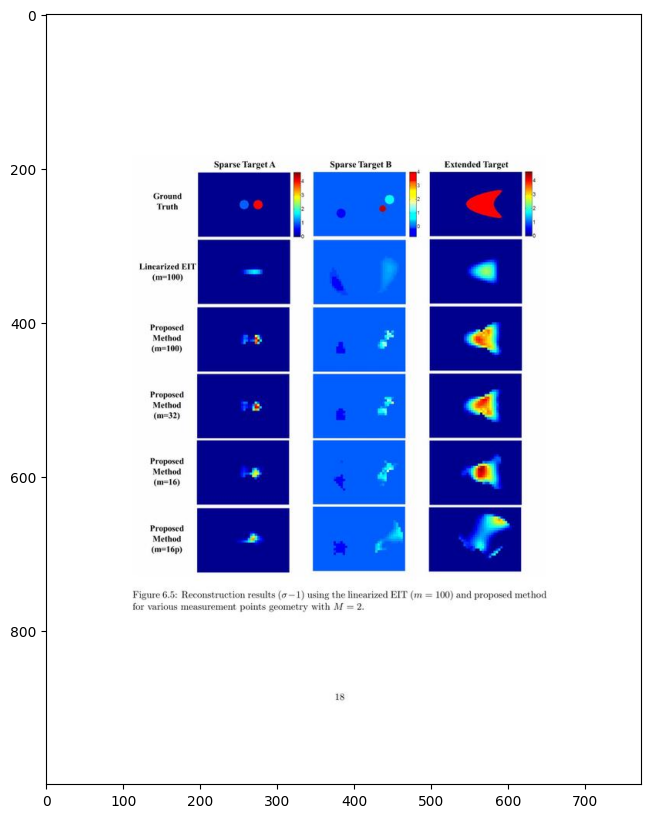

In [ ]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import torch
from ultralytics import YOLO

images_path = Path('/content/drive/MyDrive/yoloDocBankPoc/images/train')
jpg_files = list(images_path.glob('*.jpg'))

if not jpg_files:
    raise FileNotFoundError(f"No se encontraron archivos .jpg en {images_path}")

random_image_path = random.choice(jpg_files)

im = Image.open(random_image_path).convert('RGB')
transform = Compose([
    Resize((640, 640)),  # Ensure size is divisible by 32
    ToTensor()
])
show_image(im)

In [ ]:
from urllib.request import urlretrieve

yolo_labels = ['abstract',
               'author',
               'caption',
               'equation',
               'figure',
               'footer',
               'list',
               'paragraph',
               'reference',
               'section',
               'table',
               'title']

a = urlretrieve("https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt", "labels.txt")

with open("labels.txt", "r") as f:
    for line in f.readlines():
        yolo_labels.append(line.replace("\n", ""))

### Preprocessing transformations

In [ ]:
from torchvision.transforms.functional import to_tensor
x = to_tensor(im).to(device)
targets = None

In [ ]:
transformed, _ = model.transform([x], targets)

### Feature Extraction

In [ ]:
feature_maps = model.backbone(transformed.tensors)
print({k: v.shape for k, v in feature_maps.items()})

{'0': torch.Size([1, 256, 168, 128]), '1': torch.Size([1, 256, 84, 64]), '2': torch.Size([1, 256, 42, 32]), '3': torch.Size([1, 256, 21, 16]), 'pool': torch.Size([1, 256, 11, 8])}


In [ ]:
feature_maps['0']

tensor([[[[-0.1333, -0.3157, -0.2758,  ..., -0.5764, -0.5295, -0.3936],
          [-0.5517, -1.6181, -1.5373,  ..., -1.4520, -1.2030, -0.8331],
          [-0.7081, -1.7343, -1.7443,  ..., -1.5635, -1.3998, -0.9220],
          ...,
          [-0.3659, -0.9791, -1.1235,  ..., -0.1647, -0.1395, -0.2116],
          [-0.4427, -0.8780, -0.8256,  ..., -0.1402, -0.1749,  0.0312],
          [-0.5162, -0.7708, -0.7554,  ..., -0.6235, -0.7810, -0.1411]],

         [[ 0.4882,  0.5111,  0.6585,  ...,  0.3602,  0.2485,  0.0774],
          [ 1.0028,  0.8631,  0.8652,  ...,  0.7460,  0.8463,  0.7377],
          [ 0.8038,  0.7845,  0.6643,  ...,  0.3833,  0.5785,  0.5648],
          ...,
          [-0.4860, -0.2191, -0.0166,  ..., -0.2010, -0.2157,  0.2260],
          [ 0.2894,  0.3606,  0.5186,  ...,  0.4149, -0.0446,  0.6500],
          [ 0.3070,  0.2326,  0.2542,  ...,  0.2679,  0.2743,  0.4813]],

         [[ 0.1878, -0.5318, -0.5762,  ..., -0.5349, -0.3120, -0.4749],
          [ 0.0635, -0.6123, -

### Region proposal

In [ ]:
proposals, proposal_losses = model.rpn(transformed, feature_maps, targets)
proposals[0].shape

torch.Size([2000, 4])

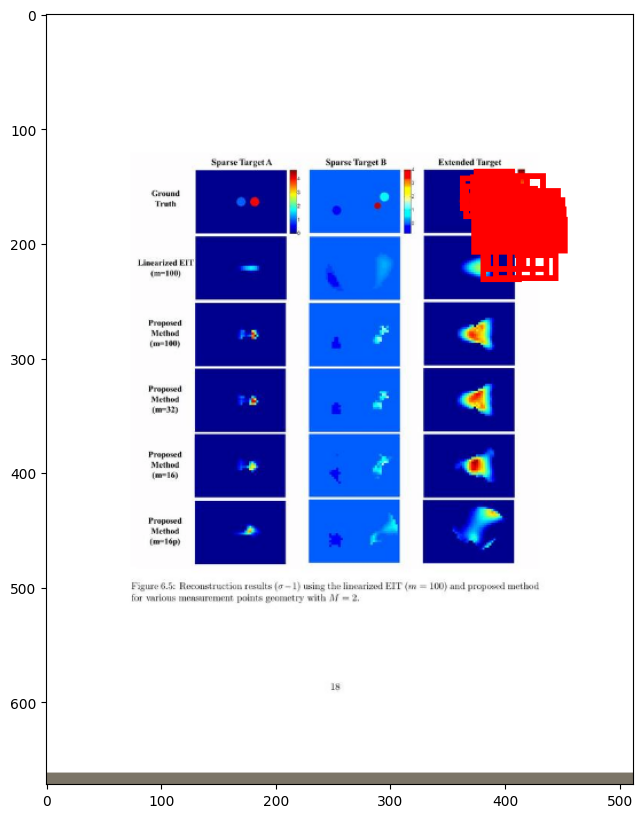

In [ ]:
from torchvision.transforms.functional import to_pil_image

aux = transformed.tensors[0].cpu()
aux = aux*torch.tensor(model.image_std).reshape(3,1,1)+torch.tensor(model.image_mean).reshape(3,1,1)
trnasformed_im = to_pil_image(aux)
draw = ImageDraw.Draw(trnasformed_im)
for p in proposals[0][:50]:
    coords = p.cpu().detach().tolist()
    draw.rectangle(coords, width=5, outline="red")
show_image(trnasformed_im)

### ROI classifier and regressor

In [ ]:
import torch.nn.functional as F

In [ ]:
detections, detector_losses = model.roi_heads(feature_maps, proposals, transformed.image_sizes, targets)
detections = model.transform.postprocess(detections, transformed.image_sizes, [[im.height, im.width]])[0]

In [ ]:
print({k: v.shape for k, v in detections.items()})

{'boxes': torch.Size([100, 4]), 'labels': torch.Size([100]), 'scores': torch.Size([100])}


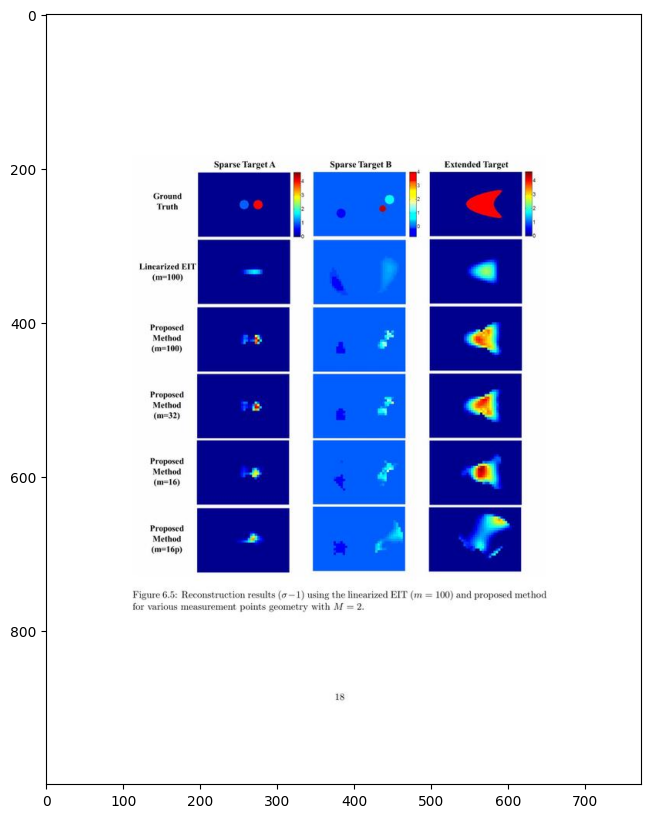

In [ ]:
import torchvision

iou_threshold = 0.2
scores_threshold = 0.6
keep_idx = torchvision.ops.nms(detections["boxes"], detections["scores"], iou_threshold)
boxes = [b for i, b in enumerate(detections["boxes"]) if i in keep_idx]
scores = [s for i, s in enumerate(detections["scores"]) if i in keep_idx]
labels = [l for i, l in enumerate(detections["labels"]) if i in keep_idx]

draw = ImageDraw.Draw(im)
for box, score, label in zip(boxes, scores, labels):
    if score > scores_threshold:
        coords = box.cpu().tolist()
        draw.rectangle(coords, width=5)
        text = f"{yolo_labels[label.item()]} {score*100:.2f}%"
        draw.text([coords[0], coords[1]-15], text)
show_image(im)

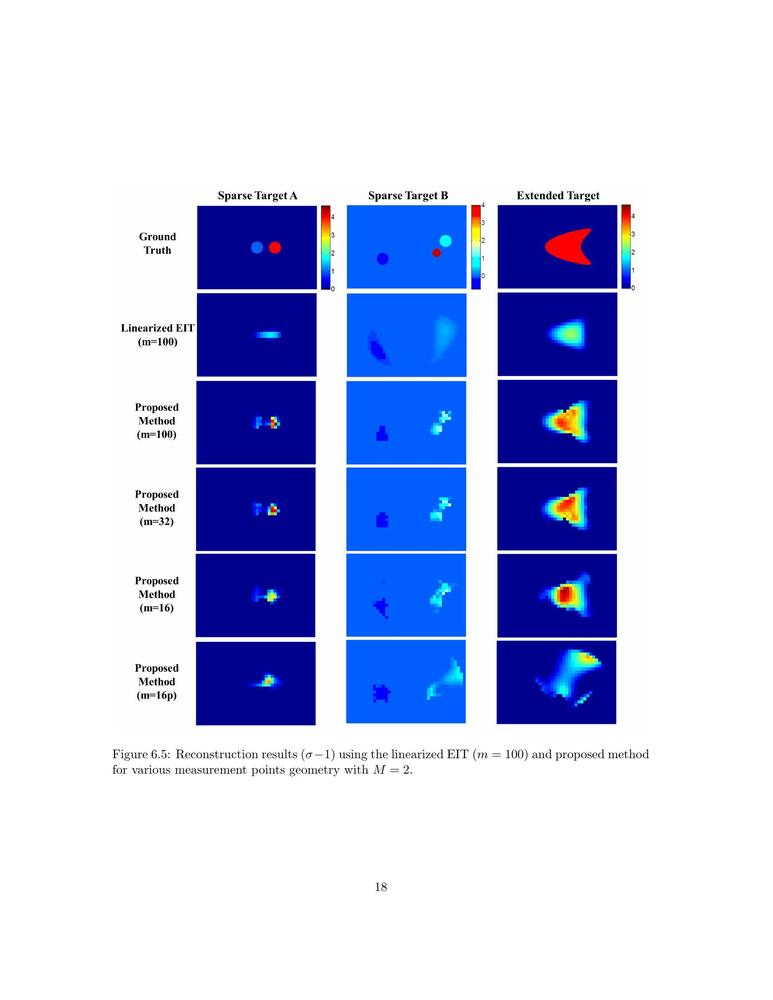

In [ ]:
im

### Transfer Learning

As we could see, the model itself is not able to detect the words over the images. We will feed the model with the data of our dataset and train it to be able to detect

In [ ]:
# Define class names
class_names = [
    'abstract', 'author', 'date', 'caption', 'equation', 'figure', 'footer',
    'list', 'paragraph', 'reference', 'section', 'table', 'title'
]

In [ ]:
import torch.optim as optim

num_classes = len(class_names)

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move model to training mode and device
model = model.train().to(device)

# create Adam optimizer for only the new predictor's parameters
optimizer = optim.Adam(
    model.roi_heads.box_predictor.parameters(),
    lr=1e-3,  # you can adjust the learning rate as needed
    weight_decay=0.0001)

## 4. Training the model

Now we will design the training loop

In [ ]:
"""
# Entrenar el modelo - EXPANDIR A UN LOOP PROPIO DE ENTRENAMIENTO
    results = model.train(
        data=data_yaml,
        epochs=100,
        imgsz=640,
        batch=16,
        device=device,
        workers=8,
        project='/content/drive/MyDrive/yolov8_results',
        name='docbank_finetune',
        exist_ok=True,
        pretrained=True,
        optimizer='auto',
        verbose=True,
        seed=42,
        deterministic=True
    )

    # Exportar modelo
    model.export(format='onnx')

    return results

"""

"\n# Entrenar el modelo - EXPANDIR A UN LOOP PROPIO DE ENTRENAMIENTO\n    results = model.train(\n        data=data_yaml,\n        epochs=100,\n        imgsz=640,\n        batch=16,\n        device=device,\n        workers=8,\n        project='/content/drive/MyDrive/yolov8_results',\n        name='docbank_finetune',\n        exist_ok=True,\n        pretrained=True,\n        optimizer='auto',\n        verbose=True,\n        seed=42,\n        deterministic=True\n    )\n\n    # Exportar modelo\n    model.export(format='onnx')\n\n    return results\n\n"

In [ ]:
import wandb

wandb.init(
    project="Computer_Vision",
    name="Word_Detector_v0.0.5",  # optional
    config={
        "epochs": 30,
        "batch_size": 32,
        "learning_rate": 0.001,
        # add other config details if desired
    }
)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: toninoguerarecasens (adriabuil-upc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import os
import glob
import numpy as np
import torch

class DocBankDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, class_names=None):
        # Store directory paths
        self.image_dir = image_dir
        self.label_dir = label_dir

        # Define default class names if not provided
        self.class_names = class_names

        # Create class to index mapping
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}

        # Get all image files from the directory
        self.image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')) +
                                glob.glob(os.path.join(image_dir, '*.jpeg')) +
                                glob.glob(os.path.join(image_dir, '*.png')))

        # Get corresponding label files
        self.label_files = []
        for img_path in self.image_files:
            # Get the base filename without extension
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            # Look for corresponding label file
            label_path = os.path.join(label_dir, f"{base_name}.txt")
            if os.path.exists(label_path):
                self.label_files.append(label_path)
            else:
                print(f"Warning: Label file not found for image {img_path}")
                continue

        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def _parse_docbank_label(self, label_path, img_width, img_height):
        boxes = []
        labels = []

        with open(label_path, 'r', encoding='utf-8') as f:
            for line in f:
                # DocBank format: text\tx1\ty1\tx2\ty2\t...
                parts = line.strip().split('\t')
                if len(parts) >= 5:  # Ensure we have at least the basic required fields
                    try:
                        x1 = int(parts[1])
                        y1 = int(parts[2])
                        x2 = int(parts[3])
                        y2 = int(parts[4])

                        # Ensure coordinates are within image bounds
                        x1 = max(0, min(x1, img_width))
                        y1 = max(0, min(y1, img_height))
                        x2 = max(0, min(x2, img_width))
                        y2 = max(0, min(y2, img_height))

                        # Skip invalid boxes
                        if x2 <= x1 or y2 <= y1:
                            continue

                        # Get class name from the last field (assuming it's the class name)
                        class_name = parts[-1].strip()
                        if class_name in self.class_to_idx:
                            class_id = self.class_to_idx[class_name]
                        else:
                            print(f"Warning: Unknown class {class_name} in {label_path}")
                            continue

                        boxes.append([x1, y1, x2, y2])
                        labels.append(class_id)
                    except (ValueError, IndexError) as e:
                        print(f"Error parsing line in {label_path}: {line}")
                        continue

        return {
            "boxes": np.array(boxes, dtype=np.float32) if boxes else np.zeros((0, 4), dtype=np.float32),
            "labels": np.array(labels, dtype=np.int64) if labels else np.zeros(0, dtype=np.int64)
        }

    def __getitem__(self, idx):
        try:
            image_path = self.image_files[idx]
            label_path = self.label_files[idx]

            try:
                image = Image.open(image_path).convert('RGB')
                image.load()
            except (OSError, IOError) as e:
                print(f"Error loading image {image_path}: {str(e)}")
                return self.__getitem__((idx + 1) % len(self))

            img_width, img_height = image.size

            target = self._parse_docbank_label(label_path, img_width, img_height)

            # Verifica que haya cajas
            if len(target["boxes"]) == 0:
                return self.__getitem__((idx + 1) % len(self))

            # Aplica transformaciones (solo ToTensor y opcional Normalize)
            if self.transform:
                image = self.transform(image)

            target = {k: torch.from_numpy(v) for k, v in target.items()}

            return image, target

        except Exception as e:
            print(f"Error processing image {idx}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))

    def verify_images(self):
        corrupted_files = []
        for idx, image_path in enumerate(self.image_files):
            try:
                with Image.open(image_path) as img:
                    img.load()
            except (OSError, IOError) as e:
                print(f"Corrupted image found: {image_path}")
                corrupted_files.append(image_path)

        if corrupted_files:
            print(f"Found {len(corrupted_files)} corrupted images")
            # Remove corrupted files from the dataset
            self.image_files = [f for f in self.image_files if f not in corrupted_files]
            self.label_files = [f for f in self.label_files if f not in corrupted_files]
            print(f"Remaining valid images: {len(self.image_files)}")
        else:
            print("All images are valid!")

    def get_class_names(self):
        """Return the list of class names"""
        return self.class_names

    def get_class_to_idx(self):
        """Return the class to index mapping"""
        return self.class_to_idx

In [ ]:
import os
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

# Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

Create the Datasets

print train_transforms = transform.ToTensor()

In [ ]:
from torchvision import transforms

# Define transforms for ResNet-50
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Instantiate your DocBankDataset with class names
train_dataset = DocBankDataset(
    image_dir='/content/drive/MyDrive/yoloDocBankPoc/images/train',
    label_dir='/content/drive/MyDrive/yoloDocBankPoc/transformed_labels/train',
    transform=train_transforms,
    class_names=class_names  # Use the original class names from the notebook
)

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation dataset with same class names
val_dataset = DocBankDataset(
    image_dir='/content/drive/MyDrive/yoloDocBankPoc/images/val',
    label_dir='/content/drive/MyDrive/yoloDocBankPoc/transformed_labels/val',
    transform=val_transforms,
    class_names=class_names  # Use the original class names from the notebook
)

Declare DataLoaders

In [ ]:
print("Verifying training dataset...")
train_dataset.verify_images()
print(f"Training dataset size: {len(train_dataset)}")

try:
    sample_image, sample_target = train_dataset[0]
    print("\nSample data verification:")
    print(f"Image shape: {sample_image.shape}")
    print(f"Target keys: {sample_target.keys()}")
    print(f"Number of boxes: {len(sample_target['boxes'])}")
    print(f"Number of labels: {len(sample_target['labels'])}")
except Exception as e:
    print(f"Error loading sample: {str(e)}")

# Modify DataLoader configuration more conservative
train_loader = DataLoader(
    train_dataset,
    batch_size=32,  # Reduced batch size
    shuffle=True,
    num_workers=8,  # Disable multiprocessing
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,  # Reduced batch size
    shuffle=False,
    num_workers=8,  # Disable multiprocessing
    pin_memory=True,
    collate_fn=collate_fn
)

Verifying training dataset...
Corrupted image found: /content/drive/MyDrive/yoloDocBankPoc/images/train/144.tar_1805.09065.gz_gascom2018_localtime_5_ori.jpg
Found 1 corrupted images
Remaining valid images: 2020
Training dataset size: 2020

Sample data verification:
Image shape: torch.Size([3, 1000, 707])
Target keys: dict_keys(['boxes', 'labels'])
Number of boxes: 942
Number of labels: 942


Declare the training method

In [ ]:
def compute_iou(box1, box2):
    x1 = torch.max(box1[0], box2[0])
    y1 = torch.max(box1[1], box2[1])
    x2 = torch.min(box1[2], box2[2])
    y2 = torch.min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    if inter_area == 0:
        return 0.0

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return inter_area / float(box1_area + box2_area - inter_area)

In [ ]:
from torch.optim.lr_scheduler import LinearLR

def train_model(epochs):
    # Make sure to set this at the very start of your script before importing torch
    # os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

    num_epochs = epochs
    num_steps_log = 10
    total_steps = len(train_loader) * num_epochs

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001,
                             weight_decay=0.0005)

    scheduler = LinearLR(optimizer,
                     start_factor=1.0,
                     end_factor=0.01,
                     total_iters=total_steps)

    wandb.watch(model, log="all", log_freq=10)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        tp_train = fp_train = fn_train = total_train = 0

        train_loss_components = {k: 0.0 for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']}

        for i, (images, targets) in enumerate(train_loader):
            try:
                if not images or not targets:
                    print(f"Empty batch at step {i}, skipping...")
                    continue

                images = [img.to(device, non_blocking=True) for img in images]
                targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

                optimizer.zero_grad(set_to_none=True)

                loss_dict = model(images, targets)
                if isinstance(loss_dict, tuple): _, loss_dict = loss_dict

                losses = sum(loss for loss in loss_dict.values())
                losses.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                train_loss += losses.item()
                for k in train_loss_components:
                    if k in loss_dict:
                        v = loss_dict[k]
                        train_loss_components[k] += v.item() if isinstance(v, torch.Tensor) else float(v)

                if i % num_steps_log == 0:
                    loss_str = ", ".join([f"{k}: {v.item():.3f}" for k, v in loss_dict.items()])
                    print(f"Step {i}/{len(train_loader)}: {loss_str}")

                del images, targets, loss_dict, losses
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error processing batch {i}: {str(e)}")
                torch.cuda.empty_cache()
                model.eval()
                time.sleep(1)
                model.train()
                continue

        train_loss /= len(train_loader)
        for k in train_loss_components:
            train_loss_components[k] /= len(train_loader)

        model.train()
        val_loss = 0.0
        num_val_batches = 0

        # initialize per-loss-component accumulators just like in training
        val_loss_components = {
            'loss_classifier': 0.0,
            'loss_box_reg': 0.0,
            'loss_objectness': 0.0,
            'loss_rpn_box_reg': 0.0
        }

        with torch.no_grad():
            for i, (images, targets) in enumerate(val_loader):
                try:
                    # 1) Move to device
                    images = [img.to(device, non_blocking=True) for img in images]
                    targets = [
                        {k: v.to(device, non_blocking=True) for k, v in t.items()}
                        for t in targets
                    ]

                    # 2) Transform (unpack ImageList + updated targets)
                    images_list, targets_transformed = model.transform(images, targets)

                    # 3) Backbone
                    features = model.backbone(images_list.tensors)
                    if isinstance(features, torch.Tensor):
                        features = {'0': features}

                    # 4) RPN → get proposals + rpn losses
                    proposals, proposal_losses = model.rpn(
                        images_list, features, targets_transformed
                    )

                    # 5) ROI heads → get detections + detector losses
                    detections, detector_losses = model.roi_heads(
                        features, proposals,
                        images_list.image_sizes,
                        targets_transformed
                    )

                    # 6) Build combined loss_dict exactly as model does internally
                    loss_dict = {}
                    loss_dict.update(proposal_losses)
                    loss_dict.update(detector_losses)

                    # 7) Sum up for scalar val_loss
                    this_batch_loss = sum(v.item() for v in loss_dict.values())
                    val_loss += this_batch_loss
                    num_val_batches += 1

                    # 8) Accumulate per-component
                    for k, v in loss_dict.items():
                        if k in val_loss_components:
                            val_loss_components[k] += v.item()

                    # 9) Log a quick print every num_steps_log
                    if i % num_steps_log == 0:
                        print(f"Validation Step {i}/{len(val_loader)}:")
                        for k, v in loss_dict.items():
                            print(f"  {k}: {v.item():.3f}")

                    # 10) Clean up
                    del images, targets, images_list, targets_transformed, loss_dict, this_batch_loss
                    torch.cuda.empty_cache()

                except Exception as e:
                    print(f"Error in validation batch {i}: {e}")
                    torch.cuda.empty_cache()
                    continue

        # Compute final averages
        if num_val_batches > 0:
            val_loss /= num_val_batches
            for k in val_loss_components:
                val_loss_components[k] /= num_val_batches
        else:
            print("⚠️ No valid validation batches.")
            val_loss = float('inf')

        # Restore eval mode for any subsequent inference
        model.eval()

        scheduler.step()

        def safe_div(x, y): return x / y if y > 0 else 0.0

        # Métricas
        metrics = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "lr": optimizer.param_groups[0]['lr'],
            "train_precision": safe_div(tp_train, tp_train + fp_train),
            "train_recall": safe_div(tp_train, tp_train + fn_train),
            "train_accuracy": safe_div(tp_train, total_train),
            "train_mAP@0.5": safe_div(tp_train, tp_train + fp_train),
            **{f'val_{k}': v for k, v in val_loss_components.items()}
        }

        # Añadir pérdidas por componente
        for k, v in train_loss_components.items():
            metrics[f"train_{k}"] = v
        for k, v in val_loss_components.items():
            metrics[f"val_{k}"] = v

        wandb.log(metrics)

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training complete")


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Paso 2: Entrenar el modelo
train_model(30)

Epoch 1/30
Step 0/64: loss_classifier: 2.639, loss_box_reg: 0.040, loss_objectness: 0.692, loss_rpn_box_reg: 0.947
Step 10/64: loss_classifier: 3.325, loss_box_reg: 6.678, loss_objectness: 0.611, loss_rpn_box_reg: 0.685
Step 20/64: loss_classifier: 0.754, loss_box_reg: 0.456, loss_objectness: 0.428, loss_rpn_box_reg: 0.600
Step 30/64: loss_classifier: 0.685, loss_box_reg: 0.170, loss_objectness: 0.329, loss_rpn_box_reg: 0.473
Error processing batch 40: CUDA out of memory. Tried to allocate 4.01 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1.97 GiB is free. Process 31164 has 37.57 GiB memory in use. Of the allocated memory 35.95 GiB is allocated by PyTorch, and 1.11 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Step 50/64: loss_classifier: 0

## 6. Evaluación del modelo

Después del entrenamiento, podemos evaluar el modelo en el conjunto de prueba:

Añadir wordcount total sobre el documento para poder evaluar la detección de las palabras.



### Save model

In [ ]:
torch.save(model.state_dict(), "model.pth")
artifact = wandb.Artifact('fasterrcnn-resnet50-model', type='model')
artifact.add_file("model.pth")
wandb.log_artifact(artifact)

ArtifactManifestEntry(path='model.pth', digest='r4lYtsOuQj9yfCfeP5jaYQ==', size=165950266, local_path='/root/.local/share/wandb/artifacts/staging/tmpf17l5thv', skip_cache=False)

In [ ]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_box_reg,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_classifier,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_objectness,█▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_rpn_box_reg,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mAP@0.5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Prediction keys: dict_keys(['boxes', 'labels', 'scores'])
Num boxes: 3
Scores: tensor([0.1547, 0.0814, 0.0702], device='cuda:0')


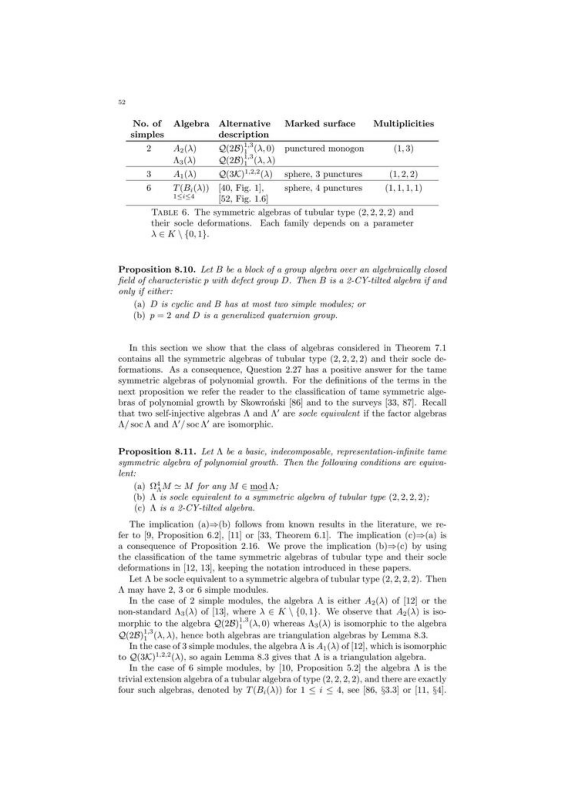

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path

# Set up base directory
dataset_dir = Path('/content/drive/MyDrive/yoloDocBankPoc')

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Create the test dataset
test_dataset = DocBankDataset(
    image_dir=dataset_dir / "images/test",
    label_dir=dataset_dir / "transformed_labels/test",
    class_names=class_names,
    transform=test_transforms
)


# Pick a test sample
idx = random.randint(0, len(test_dataset) - 1)
image, target = test_dataset[idx]
image = image.to(device)

# Run inference

model.eval()
with torch.no_grad():
    prediction = model([image])[0][0]
    print("Prediction keys:", prediction.keys())
    print("Num boxes:", len(prediction['boxes']))
    print("Scores:", prediction['scores'])


    #print(prediction)

# Move image to CPU for visualization
image_np = image.cpu().permute(1, 2, 0).numpy()

# Visualize predicted boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
ax = plt.gca()

# Draw predictions with confidence > 0.5
for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score > 0.1:
        xmin, ymin, xmax, ymax = box.cpu()
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label_name = class_names[label - 1]  # adjust for background
        ax.text(xmin, ymin - 2, f"{label_name} ({score:.2f})", color='red', fontsize=8, weight='bold')

plt.axis("off")
plt.show()

## Notas importantes

